In [1]:
import torch
from scipy import io
from tensorflow import keras
# from tsnecuda import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
embedding = np.load('/datasets/dsc180a-wi20-public/Malware/group_data/group_02/sensitive_data/processed/node2vec/graph_1.npy')

In [4]:
g = io.loadmat('/datasets/dsc180a-wi20-public/Malware/group_data/group_02/sensitive_data/interim/graph/graph_1.mat')

In [5]:
y = g['post_label'].reshape(-1,)

In [9]:
post_cate = g['post_cate']
subreddit_cate = post_cate[:, :-1]
community_cate = post_cate[:, -1]

In [6]:
def evaluate(clf, X_train, y_train, X_test, y_test):
    METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
    ]   
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    res = {}
    for i in METRICS:
        res[i.name] = i(y_test, y_pred).numpy()
    return res

In [7]:
def plot_embedding(embd, y):
    tsne = TSNE(n_components=2)
    node_embeddings_2d = tsne.fit_transform(embd)
    fig = plt.figure(figsize=(16, 16))
    for i in range(2):
        plt.scatter(node_embeddings_2d[y == i, 0], node_embeddings_2d[y == i, 1], s=10, label = i)
    plt.legend()
    plt.axis('off')
    plt.show()
    return fig

In [8]:
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(embedding)

In [9]:
cate = np.array(post_cate.todense().argmax(1)).reshape(-1,)

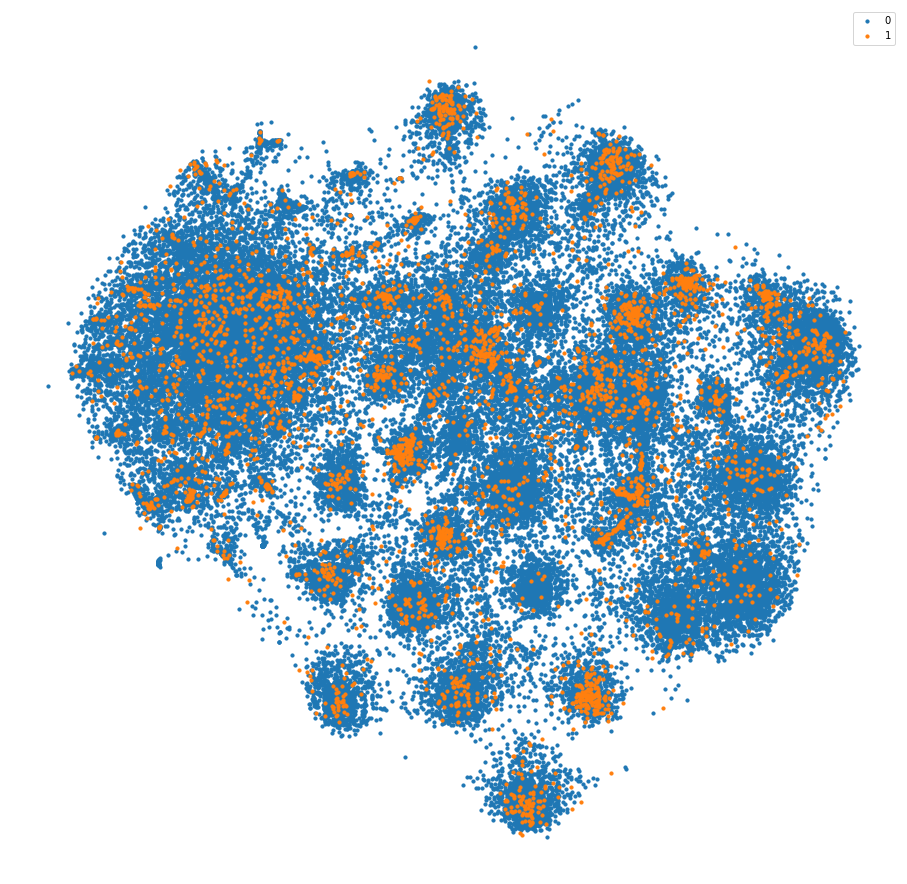

In [10]:
fig = plt.figure(figsize=(16, 16))
for i in range(2):
    plt.scatter(node_embeddings_2d[y == i, 0], node_embeddings_2d[y == i, 1], s=10, label = i)
plt.legend()
plt.axis('off')
plt.show()

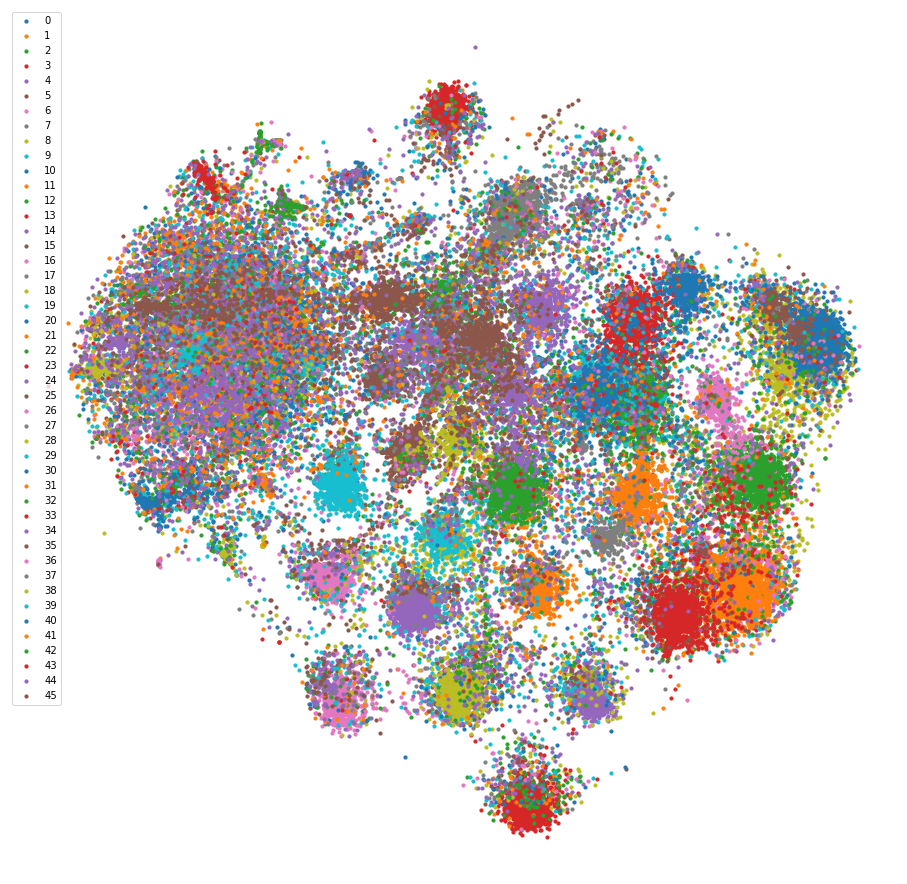

In [14]:
fig = plt.figure(figsize=(16, 16))
for i in range(46):
    plt.scatter(node_embeddings_2d[cate == i, 0], node_embeddings_2d[cate == i, 1], s=10, label = i)
plt.legend()
plt.axis('off')
plt.show()

In [15]:
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

Examples:
    Total: 103413
    Positive: 4409 (4.26% of total)



In [16]:
X_train, X_test, y_train, y_test = train_test_split(embedding, y, test_size=0.2)

In [17]:
clfs = [
        LogisticRegression(
        verbose=False, max_iter=2000, class_weight = class_weight, n_jobs=8
        ),
        LinearSVC(class_weight=class_weight),
        RandomForestClassifier(class_weight=class_weight, n_jobs=8)
    ]
res = {}
for clf in clfs:
    res[clf.__class__.__name__] = evaluate(clf, X_train, y_train, X_test, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [18]:
pd.DataFrame(res).T

,tp,fp,tn,fn,accuracy,precision,recall,auc
LogisticRegression,510.0,8121.0,11686.0,366.0,0.589663,0.059089,0.582192,0.586093
LinearSVC,421.0,6178.0,13629.0,455.0,0.679302,0.063798,0.480594,0.584342
RandomForestClassifier,0.0,0.0,19807.0,876.0,0.957646,0.000000,0.000000,0.500000


In [19]:
X_train, X_test, y_train, y_test = train_test_split(embedding, cate, test_size=0.2)

In [20]:
clfs = [
        LogisticRegression(
        verbose=False, max_iter=2000, class_weight = class_weight, n_jobs=8
        ),
#         LinearSVC(class_weight=class_weight),
        RandomForestClassifier(class_weight=class_weight, n_jobs=8)
    ]
res = {}
for clf in clfs:
    clf.fit(X_train, y_train)
    res[clf.__class__.__name__] = clf.score(X_test, y_test)

In [21]:
res

{'LogisticRegression': 0.6846685683894986,
 'RandomForestClassifier': 0.5592032103660011}